In [72]:
!pip install scikit-learn==0.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.24.0 which is incompatible.


In [70]:
!pip install -U imbalanced-learn

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd
import time
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE

In [149]:
path = '../datasets/diabetes_data_initial.csv'
data = pd.read_csv(path)

In [150]:
replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25,
'[30-40)' : 35,
'[40-50)' : 45,
'[50-60)' : 55,
'[60-70)' : 65,
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])

In [151]:
data['prev_visits'] = data.groupby('patient_nbr').encounter_id.transform(lambda x: range(len(x)))

In [152]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']
low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology', 'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric', 'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices', 'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']
pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology', 'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']
psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']
neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']
surgery = ['Surgeon', 'Surgery-Cardiovascular', 'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', 'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic', 'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases', 'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']
missing = ['?']

def get_specialty_type(specialty):
    if specialty in pediatrics : return 'pediatrics'
    elif specialty in psychic : return 'psychic'
    elif specialty in neurology : return 'neurology'
    elif specialty in surgery : return 'surgery'
    elif specialty in high_frequency : return 'high_freq'
    elif specialty in low_frequency : return 'low_freq'
    elif specialty in ungrouped : return 'ungrouped'
    elif specialty in missing : return 'missing'

data['medical_specialty'] = data['medical_specialty'].apply(get_specialty_type)

In [153]:
def get_diag(diag):
    if '?' in diag: return 'unknown'
    if 'V' in diag:  return 'health_contact'
    if 'E' in diag: return 'injury_poisoning'
    diag_no = int(float(diag))
    if diag_no in range(0, 140): return 'infectious'
    if diag_no in range(140, 240): return 'neoplasms'
    if diag_no == 250: return 'diabetes'
    if diag_no in range(251, 260): return 'endocrine'
    if diag_no in range(240, 280): return 'long_term'
    if diag_no in range(280, 290): return 'blood'
    if diag_no in range(290, 320): return 'mental'
    if diag_no in range(320, 390): return 'nervous'
    if diag_no in range(390, 460): return 'respiratory'
    if diag_no in range(520, 580): return 'digestive'
    if diag_no in range(580, 630): return 'genitourinary'
    if diag_no in range(630, 680): return 'birth'
    if diag_no in range(680, 710): return 'skin'
    if diag_no in range(710, 740): return 'musculoskeletal'
    if diag_no in range(740, 760): return 'congenital'
    if diag_no in range(760, 780): return 'prenital'
    if diag_no in range(780, 800): return 'symptoms'
    if diag_no in range(800, 1000): return 'injury_poisoning'
    return 'other'

In [154]:
data['diagnosis_1'] = data['diag_1'].apply(get_diag)
data['diagnosis_2'] = data['diag_2'].apply(get_diag)
data['diagnosis_3'] = data['diag_3'].apply(get_diag)

In [155]:
def get_diabetes_type(diag):
    if 'V' in diag or 'E' in diag or '?' in diag: return 'no_diabetes'
    diag_float = round(float(diag),1)
    if diag_float == 250.0: return 'no_complications'
    if diag_float == 250.1: return 'ketoacidosis'
    if diag_float == 250.2: return 'hyperosmolarity'
    if diag_float == 250.3: return 'other_coma'
    if diag_float == 250.4: return 'renal'
    if diag_float == 250.5: return 'ophthalmic'
    if diag_float == 250.6: return 'nuerological'
    if diag_float == 250.7: return 'peripheral'
    if diag_float == 250.8: return 'other'
    if diag_float == 250.9: return 'unspecificed'
    return 'no_diabetes'

In [156]:
data['diabetes_type_1'] = data['diag_1'].apply(get_diabetes_type)
data['diabetes_type_2'] = data['diag_2'].apply(get_diabetes_type)
data['diabetes_type_3'] = data['diag_3'].apply(get_diabetes_type)

In [157]:
data['readmitted'] = data['readmitted'].apply(lambda x : 0 if (x == '>30' or x == 'NO') else 1)
data = data.reset_index(drop=True)

In [158]:
meds_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

def get_medicine(m):
    if m == 'No' or m == 'Steady':
        return 0
    if m == 'Up' or m == 'Down':
        return 1

def get_diabetes(d):
    if d == 'Yes':
        return 1
    if d == 'No':
        return 0

def get_ch(c):
    if c == 'Ch':
        return 1
    if c == 'No':
        return 0

for m in meds_cols:
    data[m] = data[m].apply(get_medicine)
data['diabetesMed'] = data['diabetesMed'].apply(get_diabetes)
data['change'] = data['change'].apply(get_ch)

In [159]:
def get_pc(p):
    if p == '?':
        return 'Unknown'
    if p == 'MD' or p == 'MC':
        return 'Medicare'
    if p == 'SP':
        return 'SelfPay'
    return 'PrivateInsurance'
data['payer_code'] = data['payer_code'].apply(get_pc)

In [160]:
def logfunc(m):
    return math.log(m+1)

data['num_medications'] = data['num_medications'].apply(logfunc)
data['num_procedures'] = data['num_procedures'].apply(logfunc)
data['num_lab_procedures'] = data['num_lab_procedures'].apply(logfunc)
data['number_diagnoses'] = data['number_diagnoses'].apply(logfunc)
data['number_emergency'] = data['number_emergency'].apply(logfunc)
data['number_inpatient'] = data['number_inpatient'].apply(logfunc)
data['number_outpatient'] = data['number_outpatient'].apply(logfunc)
data['time_in_hospital'] = data['time_in_hospital'].apply(logfunc)

In [161]:
data['total_services'] = data['number_inpatient'] + data['number_outpatient'] + data['number_emergency']
data['change_meds'] = np.sum([data[m].astype(int) for m in meds_cols],axis=0)

In [162]:
admission_type = {
    'Emergency': 1,
    'Urgent': 2,
    'Elective': 3,
    'Newborn': 4,
    'Not available': 5,
    '': 6,
    'Trauma Center': 7,
    'Not Mapped': 8
}
admission_type_reverse = {}

for key in admission_type:
    admission_type_reverse[admission_type[key]] = key
    
data['admission_type_id'] = data['admission_type_id'].replace(admission_type['Urgent'], admission_type['Emergency']) # Urgent -> emergency
data['admission_type_id'] = data['admission_type_id'].replace(admission_type['Trauma Center'],admission_type['Emergency']) # Trauma -> emergency
data['admission_type_id'] = data['admission_type_id'].replace(admission_type[''],admission_type['Not available']) # Not available
data['admission_type_id'] = data['admission_type_id'].replace(admission_type['Not Mapped'],admission_type['Not available']) # Not available
admission_type_concise = {
     1: 'Emergency',
     3: 'Elective',
     4: 'Newborn',
     5: 'Unavailable'
}
data['admission_type'] = data['admission_type_id'].apply(lambda x: admission_type_concise[x])
data = data.drop('admission_type_id', axis=1)

In [163]:
discharge_map = {
    'Discharged home': 1,
    'Discharged to short term hospital': 2,
    'Discharged to skilled nursing facility': 3,
    'Discharged to intermediate care facility': 4,
    'Discharged to inpatient care institution': 5,
    'Discharged to home with home health service': 6,
    'Left against medical advice': 7,
    'Discharged to home under HOME IV provider': 8,
    'Admitted as inpatient to this hospital': 9,
    'Neonate discharged': 10,
    'Expired': 11,
    'Still patient': 12,
    'Hospice at home': 13,
    'Hospice at facility': 14,
    'Transferred to swing bed': 15,
    'Discharged to another institution for outpatient services': 16,
    'Discharged to this institution for outpatient services': 17,
    '': 18,
    'Expired in home': 19,
    'Expired in facility': 20,
    'Expired in unknown place': 21,
    'Discharged to rehab': 22,
    'Transferred to long-term hospital': 23,
    'Discharged to Medicaid but not Medicare-certified facility': 24,
    'Not mapped': 25,
    'Unknown/Invalid': 26,
    'Discharged to federal health care facility': 27,
    'Discharged to psychiatric hospital': 28,
    'Discharged to CAH': 29,
    'Discharged to other health care institution': 30
}


discharge_map_reverse = {}

for key in discharge_map:
    discharge_map_reverse[discharge_map[key]] = key


data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(6,1) # home w/ health services -> home
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(8,1) # 
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(9,1)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(13,1)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(3,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(4,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(5,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(14,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(22,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(23,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(24,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(12,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(15,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(16,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(17,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(25,18)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(26,18)
discharge_disposition_concise = {
     1: 'Discharged home',
     2: 'Discharged hospital',
     7: 'Left AMA',
     10: 'Neonate discharged',
     11: 'Expired',
     18: 'Unavailable',
     19: 'Expired in home',
     20: 'Expired in facility',
     27: 'Discharged federal facility',
     28: 'Discharged psychiatric hospital'
}

data['discharge_disposition'] = data['discharge_disposition_id'].apply(lambda x: discharge_disposition_concise[x])
data = data.drop('discharge_disposition_id', axis=1)

In [164]:
admission_source = {
    'Physician referral': 1,
    'Clinic referral': 2,
    'HMO Referral': 3,
    'Transfer from hospital': 4,
    'Transfer from skilled nursing facility': 5,
    'Transfer from another health facility': 6,
    'Emergency Room': 7,
    'Law enforcement': 8,
    'Not available': 9,
    'Transfer from critical access hospital': 10,
    'Normal delivery': 11,
    'Premature delivery': 12,
    'Sick baby': 13,
    'Extramural birth': 14,
    'Not available': 15,
    '': 17,
    'Transfer from another home health agency': 18,
    'Readmission to same home health agency': 19,
    'Not mapped': 20,
    'Unknown/Invalid': 21,
    'Transfer from hospital inpatient': 22,
    'Born inside this hospital': 23,
    'Born outside this hospital': 24,
    'Transfer from ambulatory surgery center': 25,
    'Transfer from hospice': 26
}

admission_source_reverse = {}

for key in admission_source:
    admission_source_reverse[admission_source[key]] = key


data['admission_source_id'] = data['admission_source_id'].replace(2,1)
data['admission_source_id'] = data['admission_source_id'].replace(3,1)
data['admission_source_id'] = data['admission_source_id'].replace(5,4)
data['admission_source_id'] = data['admission_source_id'].replace(6,4)
data['admission_source_id'] = data['admission_source_id'].replace(10,4)
data['admission_source_id'] = data['admission_source_id'].replace(22,4)
data['admission_source_id'] = data['admission_source_id'].replace(25,4)
data['admission_source_id'] = data['admission_source_id'].replace(15,9)
data['admission_source_id'] = data['admission_source_id'].replace(17,9)
data['admission_source_id'] = data['admission_source_id'].replace(20,9)
data['admission_source_id'] = data['admission_source_id'].replace(21,9)
data['admission_source_id'] = data['admission_source_id'].replace(13,11)
data['admission_source_id'] = data['admission_source_id'].replace(14,11)

admission_source_concise = {
     1: 'Physician referral',
     4: 'Transfer hospital',
     7: 'Emergency Room',
     8: 'Law enforcement',
     9: 'Not available',
     11: 'Delivery'
}
data['admission_source'] = data['admission_source_id'].apply(lambda x: admission_source_concise[x])
data = data.drop('admission_source_id', axis=1)

In [165]:
from sklearn.preprocessing import MultiLabelBinarizer
def multi_encode(cols):
    to_encode = data[cols].apply(list, axis=1)
    mlb = MultiLabelBinarizer()
    return pd.DataFrame(mlb.fit_transform(to_encode),
                   columns=mlb.classes_,
                   index=to_encode.index)
diagnosis_cols = ['diagnosis_1', 'diagnosis_2', 'diagnosis_3']
diabetes_cols = ['diabetes_type_1', 'diabetes_type_2', 'diabetes_type_3']
data = data.join(multi_encode(diagnosis_cols).add_prefix('diagnosis_'))
data = data.join(multi_encode(diabetes_cols).add_prefix('diabetes_'))

In [166]:
data = data.drop(diagnosis_cols, axis=1)
data = data.drop(diabetes_cols, axis=1)

In [167]:
cat_vars = ['race', 'gender', 'admission_type', 'discharge_disposition', 'admission_source', 'medical_specialty', 'max_glu_serum', 'A1Cresult']
for var in cat_vars:
    data = data.join(pd.get_dummies(data[var], prefix=var))
    data = data.drop(var, axis=1)

In [117]:
to_drop = ['encounter_id', 'patient_nbr', 'payer_code', 'readmitted', 'diag_1', 'diag_2', 'diag_3', 'weight'] + cat_vars + ['readmitted']
X = data[[c for c in data.columns if c not in to_drop]]
y = data['readmitted']

In [170]:
to_drop = ['encounter_id', 'time_in_hospital', 'patient_nbr', 'payer_code', 'readmitted', 'diag_1', 'diag_2', 'diag_3', 'weight'] + cat_vars + ['readmitted']
X = data[[c for c in data.columns if c not in to_drop]]
y = data['time_in_hospital']

In [118]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [172]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [176]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
model.fit(X_train, y_train)

ElasticNet()

In [182]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(y_test, pred)) 

0.5296059730968857

In [180]:
print(len(pred))

25442


In [119]:
from sklearn.model_selection import train_test_split

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE()
train_input_new, train_output_new = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(train_output_new)))


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [121]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

In [122]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

In [124]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
14466/14466 [==============================] - 66s 4ms/step - loss: 0.4107 - accuracy: 0.8204
Epoch 2/5
14466/14466 [==============================] - 61s 4ms/step - loss: 0.3920 - accuracy: 0.8294
Epoch 3/5
14466/14466 [==============================] - 63s 4ms/step - loss: 0.3838 - accuracy: 0.8336
Epoch 4/5
14466/14466 [==============================] - 66s 5ms/step - loss: 0.3814 - accuracy: 0.8348
Epoch 5/5
14466/14466 [==============================] - 64s 4ms/step - loss: 0.3750 - accuracy: 0.8380


In [125]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1131/1131 [==============================] - 4s 2ms/step - loss: 0.3479 - accuracy: 0.8622
Accuracy: 86.22


In [127]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [128]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [131]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[11:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [132]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.426144


In [134]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [135]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


[11:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [136]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.326646
Name: test-rmse-mean, dtype: float64


In [138]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 KB 667.9 kB/s eta 0:00:00


[12:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

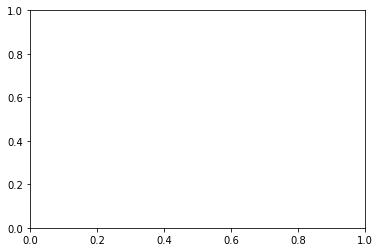

In [139]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()


xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [146]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [142]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [143]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [144]:
y_pred = model.predict(X_test)

In [147]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9365114478486893